In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 200
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-01 18:12:06.298617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 18:12:06.299539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 18:12:06.472811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 18:12:06.780969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sat Jun  1 18:12:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0             163W / 400W |  39682MiB / 40960MiB |     76%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   44C    P0             132W / 400W |  27578MiB / 40960MiB |     91%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A   2690305      C   /usr/local/bin/ollama                       688MiB |
|    0   N

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.50 minutes___


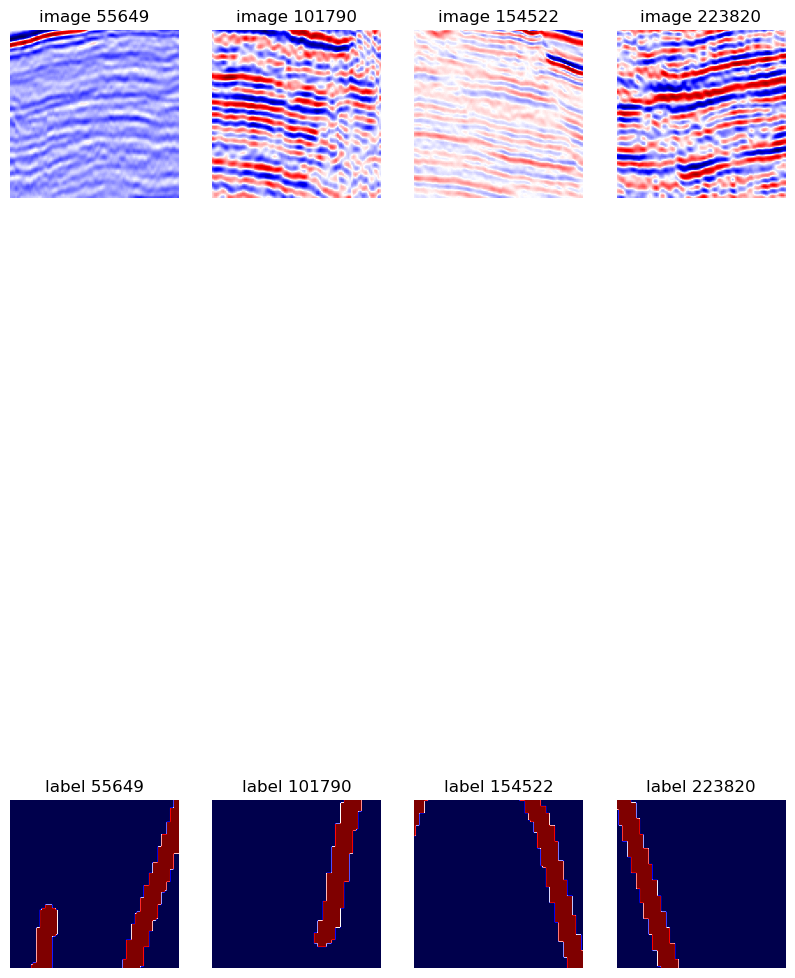

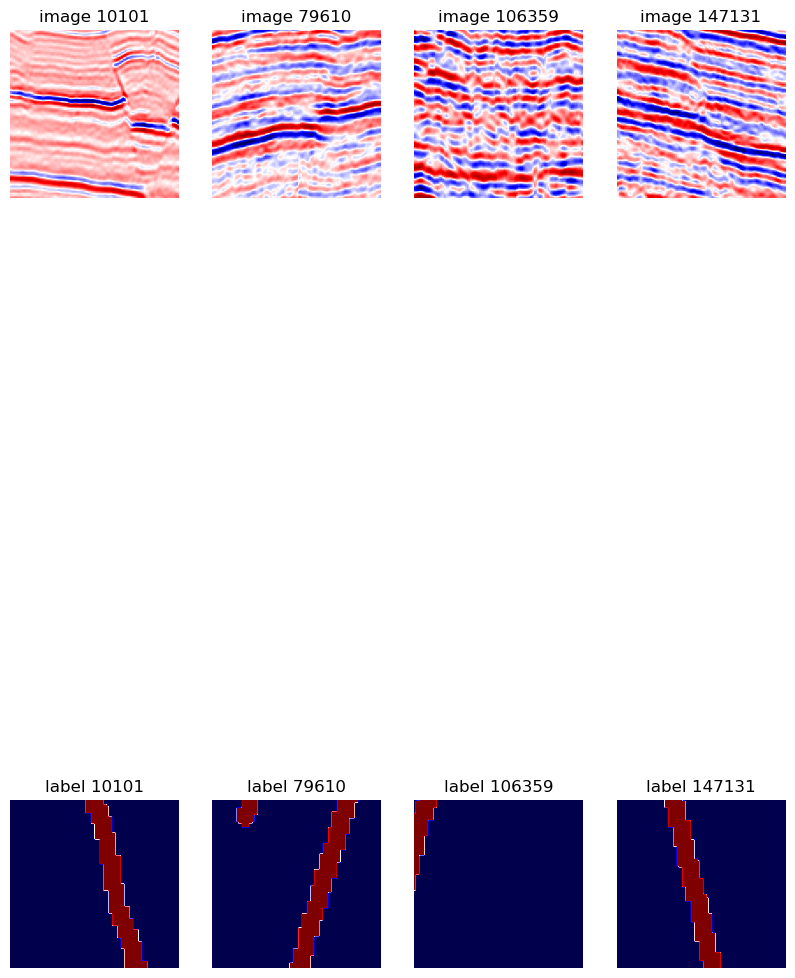

In [7]:
if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, num_images=4)
    seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/fnet',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./Thebe/fnet
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 200
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-06-01 18:13:29.350113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37783 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 6,824,641
Total trainable wieghts: 6,815,297
Total non-trainable wieghts: 9,344


### Train  model



	Train fnet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/fnet
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.python

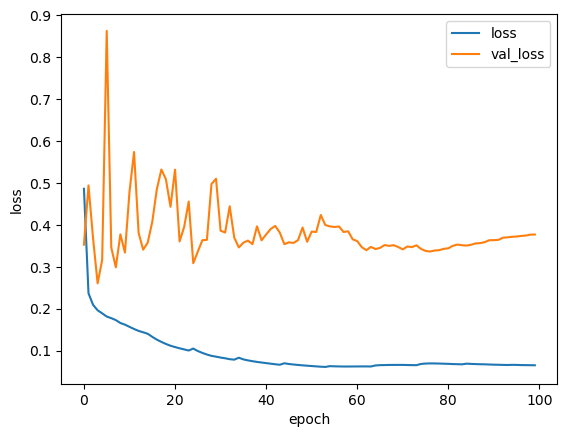

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


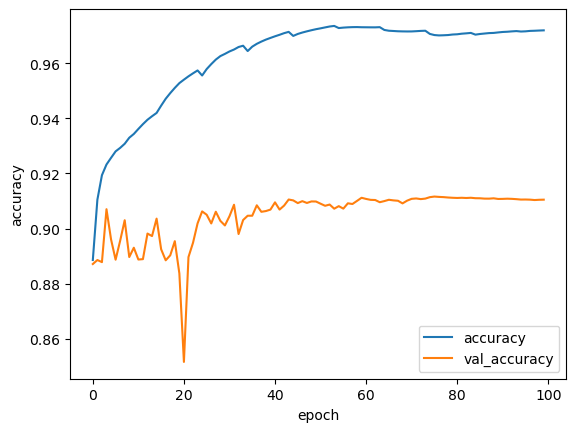

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

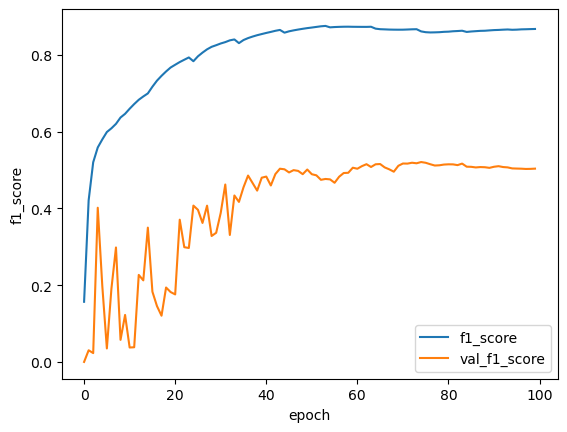

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

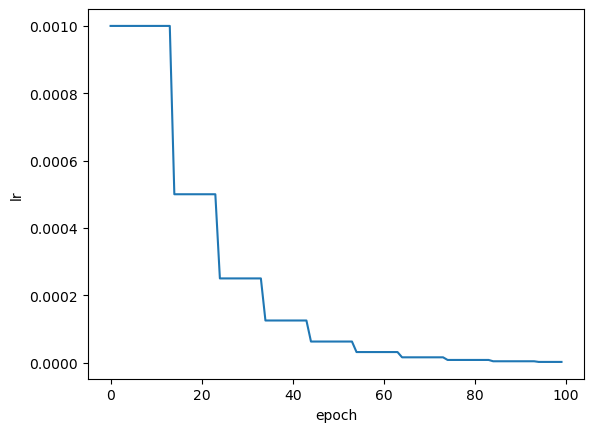

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate fnet model
-------------------------------------------------------


2024-06-01 18:14:45.266184: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/7004 [..............................] - ETA: 27:53:20

   6/7004 [..............................] - ETA: 1:17    

  11/7004 [..............................] - ETA: 1:20

  16/7004 [..............................] - ETA: 1:18

  21/7004 [..............................] - ETA: 1:18

  26/7004 [..............................] - ETA: 1:19

  31/7004 [..............................] - ETA: 1:18

  36/7004 [..............................] - ETA: 1:18

  41/7004 [..............................] - ETA: 1:18

  46/7004 [..............................] - ETA: 1:18

  51/7004 [..............................] - ETA: 1:18

  56/7004 [..............................] - ETA: 1:18

  61/7004 [..............................] - ETA: 1:18

  66/7004 [..............................] - ETA: 1:18

  71/7004 [..............................] - ETA: 1:18

  76/7004 [..............................] - ETA: 1:18

  81/7004 [..............................] - ETA: 1:18

  86/7004 [..............................] - ETA: 1:18

  91/7004 [..............................] - ETA: 1:18

  96/7004 [..............................] - ETA: 1:18

 101/7004 [..............................] - ETA: 1:18

 106/7004 [..............................] - ETA: 1:18

 111/7004 [..............................] - ETA: 1:18

 116/7004 [..............................] - ETA: 1:18

 121/7004 [..............................] - ETA: 1:17

 126/7004 [..............................] - ETA: 1:17

 131/7004 [..............................] - ETA: 1:17

 136/7004 [..............................] - ETA: 1:17

 141/7004 [..............................] - ETA: 1:17

 146/7004 [..............................] - ETA: 1:17

 151/7004 [..............................] - ETA: 1:17

 156/7004 [..............................] - ETA: 1:17

 161/7004 [..............................] - ETA: 1:17

 166/7004 [..............................] - ETA: 1:17

 171/7004 [..............................] - ETA: 1:17

 176/7004 [..............................] - ETA: 1:17

 181/7004 [..............................] - ETA: 1:17

 186/7004 [..............................] - ETA: 1:17

 191/7004 [..............................] - ETA: 1:17

 196/7004 [..............................] - ETA: 1:17

 201/7004 [..............................] - ETA: 1:17

 206/7004 [..............................] - ETA: 1:16

 211/7004 [..............................] - ETA: 1:16

 216/7004 [..............................] - ETA: 1:16

 221/7004 [..............................] - ETA: 1:16

 226/7004 [..............................] - ETA: 1:16

 231/7004 [..............................] - ETA: 1:16

 236/7004 [>.............................] - ETA: 1:16

 241/7004 [>.............................] - ETA: 1:16

 246/7004 [>.............................] - ETA: 1:16

 251/7004 [>.............................] - ETA: 1:16

 256/7004 [>.............................] - ETA: 1:16

 261/7004 [>.............................] - ETA: 1:16

 266/7004 [>.............................] - ETA: 1:16

 271/7004 [>.............................] - ETA: 1:16

 276/7004 [>.............................] - ETA: 1:16

 281/7004 [>.............................] - ETA: 1:16

 286/7004 [>.............................] - ETA: 1:16

 291/7004 [>.............................] - ETA: 1:16

 296/7004 [>.............................] - ETA: 1:15

 301/7004 [>.............................] - ETA: 1:15

 306/7004 [>.............................] - ETA: 1:15

 311/7004 [>.............................] - ETA: 1:15

 316/7004 [>.............................] - ETA: 1:15

 321/7004 [>.............................] - ETA: 1:15

 326/7004 [>.............................] - ETA: 1:15

 331/7004 [>.............................] - ETA: 1:15

 336/7004 [>.............................] - ETA: 1:15

 341/7004 [>.............................] - ETA: 1:15

 346/7004 [>.............................] - ETA: 1:15

 351/7004 [>.............................] - ETA: 1:15

 356/7004 [>.............................] - ETA: 1:15

 361/7004 [>.............................] - ETA: 1:15

 366/7004 [>.............................] - ETA: 1:15

 371/7004 [>.............................] - ETA: 1:15

 376/7004 [>.............................] - ETA: 1:15

 381/7004 [>.............................] - ETA: 1:15

 386/7004 [>.............................] - ETA: 1:14

 391/7004 [>.............................] - ETA: 1:14

 396/7004 [>.............................] - ETA: 1:14

 401/7004 [>.............................] - ETA: 1:14

 406/7004 [>.............................] - ETA: 1:14

 411/7004 [>.............................] - ETA: 1:14

 416/7004 [>.............................] - ETA: 1:14

 421/7004 [>.............................] - ETA: 1:14

 426/7004 [>.............................] - ETA: 1:14

 431/7004 [>.............................] - ETA: 1:14

 436/7004 [>.............................] - ETA: 1:14

 441/7004 [>.............................] - ETA: 1:14

 446/7004 [>.............................] - ETA: 1:14

 451/7004 [>.............................] - ETA: 1:14

 456/7004 [>.............................] - ETA: 1:14

 461/7004 [>.............................] - ETA: 1:14

 466/7004 [>.............................] - ETA: 1:14

 471/7004 [=>............................] - ETA: 1:14

 476/7004 [=>............................] - ETA: 1:14

 481/7004 [=>............................] - ETA: 1:14

 486/7004 [=>............................] - ETA: 1:13

 491/7004 [=>............................] - ETA: 1:13

 496/7004 [=>............................] - ETA: 1:13

 501/7004 [=>............................] - ETA: 1:13

 506/7004 [=>............................] - ETA: 1:13

 511/7004 [=>............................] - ETA: 1:13

 516/7004 [=>............................] - ETA: 1:13

 521/7004 [=>............................] - ETA: 1:13

 526/7004 [=>............................] - ETA: 1:13

 531/7004 [=>............................] - ETA: 1:13

 536/7004 [=>............................] - ETA: 1:13

 541/7004 [=>............................] - ETA: 1:13

 546/7004 [=>............................] - ETA: 1:13

 551/7004 [=>............................] - ETA: 1:13

 556/7004 [=>............................] - ETA: 1:13

 561/7004 [=>............................] - ETA: 1:13

 566/7004 [=>............................] - ETA: 1:13

 571/7004 [=>............................] - ETA: 1:12

 576/7004 [=>............................] - ETA: 1:12

 581/7004 [=>............................] - ETA: 1:12

 586/7004 [=>............................] - ETA: 1:12

 591/7004 [=>............................] - ETA: 1:12

 596/7004 [=>............................] - ETA: 1:12

 601/7004 [=>............................] - ETA: 1:12

 606/7004 [=>............................] - ETA: 1:12

 611/7004 [=>............................] - ETA: 1:12

 616/7004 [=>............................] - ETA: 1:12

 621/7004 [=>............................] - ETA: 1:12

 626/7004 [=>............................] - ETA: 1:12

 631/7004 [=>............................] - ETA: 1:12

 636/7004 [=>............................] - ETA: 1:12

 641/7004 [=>............................] - ETA: 1:12

 646/7004 [=>............................] - ETA: 1:12

 651/7004 [=>............................] - ETA: 1:12

 656/7004 [=>............................] - ETA: 1:12

 661/7004 [=>............................] - ETA: 1:12

 666/7004 [=>............................] - ETA: 1:12

 671/7004 [=>............................] - ETA: 1:11

 676/7004 [=>............................] - ETA: 1:11

 681/7004 [=>............................] - ETA: 1:11

 686/7004 [=>............................] - ETA: 1:11

 691/7004 [=>............................] - ETA: 1:11

 696/7004 [=>............................] - ETA: 1:11

 701/7004 [==>...........................] - ETA: 1:11

 706/7004 [==>...........................] - ETA: 1:11

 711/7004 [==>...........................] - ETA: 1:11

 716/7004 [==>...........................] - ETA: 1:11

 721/7004 [==>...........................] - ETA: 1:11

 726/7004 [==>...........................] - ETA: 1:11

 731/7004 [==>...........................] - ETA: 1:11

 736/7004 [==>...........................] - ETA: 1:11

 741/7004 [==>...........................] - ETA: 1:11

 746/7004 [==>...........................] - ETA: 1:11

 751/7004 [==>...........................] - ETA: 1:11

 756/7004 [==>...........................] - ETA: 1:11

 761/7004 [==>...........................] - ETA: 1:10

 766/7004 [==>...........................] - ETA: 1:10

 771/7004 [==>...........................] - ETA: 1:10

 776/7004 [==>...........................] - ETA: 1:10

 781/7004 [==>...........................] - ETA: 1:10

 786/7004 [==>...........................] - ETA: 1:10

 791/7004 [==>...........................] - ETA: 1:10

 796/7004 [==>...........................] - ETA: 1:10

 801/7004 [==>...........................] - ETA: 1:10

 806/7004 [==>...........................] - ETA: 1:10

 811/7004 [==>...........................] - ETA: 1:10

 816/7004 [==>...........................] - ETA: 1:10

 821/7004 [==>...........................] - ETA: 1:10

 826/7004 [==>...........................] - ETA: 1:10

 831/7004 [==>...........................] - ETA: 1:10

 836/7004 [==>...........................] - ETA: 1:10

 841/7004 [==>...........................] - ETA: 1:10

 846/7004 [==>...........................] - ETA: 1:10

 851/7004 [==>...........................] - ETA: 1:10

 856/7004 [==>...........................] - ETA: 1:09

 861/7004 [==>...........................] - ETA: 1:09

 866/7004 [==>...........................] - ETA: 1:09

 871/7004 [==>...........................] - ETA: 1:09

 876/7004 [==>...........................] - ETA: 1:09

 881/7004 [==>...........................] - ETA: 1:09

 886/7004 [==>...........................] - ETA: 1:09

 891/7004 [==>...........................] - ETA: 1:09

 896/7004 [==>...........................] - ETA: 1:09

 901/7004 [==>...........................] - ETA: 1:09

 906/7004 [==>...........................] - ETA: 1:09

 911/7004 [==>...........................] - ETA: 1:09

 916/7004 [==>...........................] - ETA: 1:09

 921/7004 [==>...........................] - ETA: 1:09

 926/7004 [==>...........................] - ETA: 1:09

 931/7004 [==>...........................] - ETA: 1:09

 936/7004 [===>..........................] - ETA: 1:09

 940/7004 [===>..........................] - ETA: 1:09

 945/7004 [===>..........................] - ETA: 1:09

 950/7004 [===>..........................] - ETA: 1:08

 955/7004 [===>..........................] - ETA: 1:08

 960/7004 [===>..........................] - ETA: 1:08

 965/7004 [===>..........................] - ETA: 1:08

 970/7004 [===>..........................] - ETA: 1:08

 975/7004 [===>..........................] - ETA: 1:08

 980/7004 [===>..........................] - ETA: 1:08

 985/7004 [===>..........................] - ETA: 1:08

 990/7004 [===>..........................] - ETA: 1:08

 995/7004 [===>..........................] - ETA: 1:08

1000/7004 [===>..........................] - ETA: 1:08

1005/7004 [===>..........................] - ETA: 1:08

1010/7004 [===>..........................] - ETA: 1:08

1015/7004 [===>..........................] - ETA: 1:08

1020/7004 [===>..........................] - ETA: 1:08

1025/7004 [===>..........................] - ETA: 1:08

1030/7004 [===>..........................] - ETA: 1:08

1035/7004 [===>..........................] - ETA: 1:08

1040/7004 [===>..........................] - ETA: 1:07

1045/7004 [===>..........................] - ETA: 1:07

1050/7004 [===>..........................] - ETA: 1:07

1055/7004 [===>..........................] - ETA: 1:07

1059/7004 [===>..........................] - ETA: 1:07

1064/7004 [===>..........................] - ETA: 1:07

1069/7004 [===>..........................] - ETA: 1:07

1074/7004 [===>..........................] - ETA: 1:07

1079/7004 [===>..........................] - ETA: 1:07

1084/7004 [===>..........................] - ETA: 1:07

1089/7004 [===>..........................] - ETA: 1:07

1094/7004 [===>..........................] - ETA: 1:07

1099/7004 [===>..........................] - ETA: 1:07

1104/7004 [===>..........................] - ETA: 1:07

1109/7004 [===>..........................] - ETA: 1:07

1114/7004 [===>..........................] - ETA: 1:07

1119/7004 [===>..........................] - ETA: 1:07

1124/7004 [===>..........................] - ETA: 1:07

1129/7004 [===>..........................] - ETA: 1:06

1134/7004 [===>..........................] - ETA: 1:06

1139/7004 [===>..........................] - ETA: 1:06

1144/7004 [===>..........................] - ETA: 1:06

1149/7004 [===>..........................] - ETA: 1:06

1154/7004 [===>..........................] - ETA: 1:06

1159/7004 [===>..........................] - ETA: 1:06

1164/7004 [===>..........................] - ETA: 1:06

1169/7004 [====>.........................] - ETA: 1:06

1174/7004 [====>.........................] - ETA: 1:06

1179/7004 [====>.........................] - ETA: 1:06

1184/7004 [====>.........................] - ETA: 1:06

1189/7004 [====>.........................] - ETA: 1:06

1194/7004 [====>.........................] - ETA: 1:06

1199/7004 [====>.........................] - ETA: 1:06

1204/7004 [====>.........................] - ETA: 1:06

1209/7004 [====>.........................] - ETA: 1:06

1214/7004 [====>.........................] - ETA: 1:06

1218/7004 [====>.........................] - ETA: 1:06

1223/7004 [====>.........................] - ETA: 1:05

1228/7004 [====>.........................] - ETA: 1:05

1233/7004 [====>.........................] - ETA: 1:05

1238/7004 [====>.........................] - ETA: 1:05

1242/7004 [====>.........................] - ETA: 1:05

1247/7004 [====>.........................] - ETA: 1:05

1252/7004 [====>.........................] - ETA: 1:05

1257/7004 [====>.........................] - ETA: 1:05

1262/7004 [====>.........................] - ETA: 1:05

1267/7004 [====>.........................] - ETA: 1:05

1272/7004 [====>.........................] - ETA: 1:05

1276/7004 [====>.........................] - ETA: 1:05

1281/7004 [====>.........................] - ETA: 1:05

1286/7004 [====>.........................] - ETA: 1:05

1291/7004 [====>.........................] - ETA: 1:05

1296/7004 [====>.........................] - ETA: 1:05

1301/7004 [====>.........................] - ETA: 1:05

1306/7004 [====>.........................] - ETA: 1:05

1311/7004 [====>.........................] - ETA: 1:04

1316/7004 [====>.........................] - ETA: 1:04

1321/7004 [====>.........................] - ETA: 1:04

1326/7004 [====>.........................] - ETA: 1:04

1331/7004 [====>.........................] - ETA: 1:04

1336/7004 [====>.........................] - ETA: 1:04

1341/7004 [====>.........................] - ETA: 1:04

1346/7004 [====>.........................] - ETA: 1:04

1351/7004 [====>.........................] - ETA: 1:04

1356/7004 [====>.........................] - ETA: 1:04

1361/7004 [====>.........................] - ETA: 1:04

1366/7004 [====>.........................] - ETA: 1:04

1371/7004 [====>.........................] - ETA: 1:04

1376/7004 [====>.........................] - ETA: 1:04

1381/7004 [====>.........................] - ETA: 1:04

1386/7004 [====>.........................] - ETA: 1:04

1391/7004 [====>.........................] - ETA: 1:04

1396/7004 [====>.........................] - ETA: 1:03

1401/7004 [=====>........................] - ETA: 1:03

1406/7004 [=====>........................] - ETA: 1:03

1411/7004 [=====>........................] - ETA: 1:03

1416/7004 [=====>........................] - ETA: 1:03

1421/7004 [=====>........................] - ETA: 1:03

1426/7004 [=====>........................] - ETA: 1:03

1431/7004 [=====>........................] - ETA: 1:03

1436/7004 [=====>........................] - ETA: 1:03

1441/7004 [=====>........................] - ETA: 1:03

1446/7004 [=====>........................] - ETA: 1:03

1451/7004 [=====>........................] - ETA: 1:03

1456/7004 [=====>........................] - ETA: 1:03

1461/7004 [=====>........................] - ETA: 1:03

1466/7004 [=====>........................] - ETA: 1:03

1471/7004 [=====>........................] - ETA: 1:03

1475/7004 [=====>........................] - ETA: 1:03

1480/7004 [=====>........................] - ETA: 1:03

1485/7004 [=====>........................] - ETA: 1:02

1490/7004 [=====>........................] - ETA: 1:02

1495/7004 [=====>........................] - ETA: 1:02

1500/7004 [=====>........................] - ETA: 1:02

1505/7004 [=====>........................] - ETA: 1:02

1510/7004 [=====>........................] - ETA: 1:02

1515/7004 [=====>........................] - ETA: 1:02

1520/7004 [=====>........................] - ETA: 1:02

1525/7004 [=====>........................] - ETA: 1:02

1530/7004 [=====>........................] - ETA: 1:02

1535/7004 [=====>........................] - ETA: 1:02

1540/7004 [=====>........................] - ETA: 1:02

1545/7004 [=====>........................] - ETA: 1:02

1550/7004 [=====>........................] - ETA: 1:02

1555/7004 [=====>........................] - ETA: 1:02

1560/7004 [=====>........................] - ETA: 1:02

1565/7004 [=====>........................] - ETA: 1:02

1570/7004 [=====>........................] - ETA: 1:01

1575/7004 [=====>........................] - ETA: 1:01

1580/7004 [=====>........................] - ETA: 1:01

1585/7004 [=====>........................] - ETA: 1:01

1590/7004 [=====>........................] - ETA: 1:01

1594/7004 [=====>........................] - ETA: 1:01

1599/7004 [=====>........................] - ETA: 1:01

1604/7004 [=====>........................] - ETA: 1:01

1609/7004 [=====>........................] - ETA: 1:01

1614/7004 [=====>........................] - ETA: 1:01

1619/7004 [=====>........................] - ETA: 1:01

1624/7004 [=====>........................] - ETA: 1:01

1629/7004 [=====>........................] - ETA: 1:01

1634/7004 [=====>........................] - ETA: 1:01

1639/7004 [======>.......................] - ETA: 1:01

1644/7004 [======>.......................] - ETA: 1:01

1649/7004 [======>.......................] - ETA: 1:01

1654/7004 [======>.......................] - ETA: 1:01

1659/7004 [======>.......................] - ETA: 1:00

1664/7004 [======>.......................] - ETA: 1:00

1669/7004 [======>.......................] - ETA: 1:00

1674/7004 [======>.......................] - ETA: 1:00

1679/7004 [======>.......................] - ETA: 1:00

1684/7004 [======>.......................] - ETA: 1:00

1688/7004 [======>.......................] - ETA: 1:00

1693/7004 [======>.......................] - ETA: 1:00

1698/7004 [======>.......................] - ETA: 1:00

1703/7004 [======>.......................] - ETA: 1:00

1708/7004 [======>.......................] - ETA: 1:00

1713/7004 [======>.......................] - ETA: 1:00

1717/7004 [======>.......................] - ETA: 1:00

1722/7004 [======>.......................] - ETA: 1:00

1727/7004 [======>.......................] - ETA: 1:00

1732/7004 [======>.......................] - ETA: 1:00

1737/7004 [======>.......................] - ETA: 1:00

1742/7004 [======>.......................] - ETA: 1:00

1747/7004 [======>.......................] - ETA: 1:00

1752/7004 [======>.......................] - ETA: 1:00

1757/7004 [======>.......................] - ETA: 59s 

1762/7004 [======>.......................] - ETA: 59s

1767/7004 [======>.......................] - ETA: 59s

1772/7004 [======>.......................] - ETA: 59s

1777/7004 [======>.......................] - ETA: 59s

1782/7004 [======>.......................] - ETA: 59s

1787/7004 [======>.......................] - ETA: 59s

1792/7004 [======>.......................] - ETA: 59s

1797/7004 [======>.......................] - ETA: 59s

1802/7004 [======>.......................] - ETA: 59s

1807/7004 [======>.......................] - ETA: 59s

1812/7004 [======>.......................] - ETA: 59s

1817/7004 [======>.......................] - ETA: 59s

1822/7004 [======>.......................] - ETA: 59s

1827/7004 [======>.......................] - ETA: 59s

1832/7004 [======>.......................] - ETA: 59s

1837/7004 [======>.......................] - ETA: 59s

1842/7004 [======>.......................] - ETA: 58s

1847/7004 [======>.......................] - ETA: 58s

1852/7004 [======>.......................] - ETA: 58s

1857/7004 [======>.......................] - ETA: 58s

1862/7004 [======>.......................] - ETA: 58s

1867/7004 [======>.......................] - ETA: 58s

1872/7004 [=======>......................] - ETA: 58s

1877/7004 [=======>......................] - ETA: 58s

1882/7004 [=======>......................] - ETA: 58s

1887/7004 [=======>......................] - ETA: 58s

1892/7004 [=======>......................] - ETA: 58s

1897/7004 [=======>......................] - ETA: 58s

1902/7004 [=======>......................] - ETA: 58s

1907/7004 [=======>......................] - ETA: 58s

1912/7004 [=======>......................] - ETA: 58s

1917/7004 [=======>......................] - ETA: 58s

1922/7004 [=======>......................] - ETA: 58s

1927/7004 [=======>......................] - ETA: 58s

1932/7004 [=======>......................] - ETA: 57s

1937/7004 [=======>......................] - ETA: 57s

1942/7004 [=======>......................] - ETA: 57s

1947/7004 [=======>......................] - ETA: 57s

1952/7004 [=======>......................] - ETA: 57s

1957/7004 [=======>......................] - ETA: 57s

1962/7004 [=======>......................] - ETA: 57s

1967/7004 [=======>......................] - ETA: 57s

1972/7004 [=======>......................] - ETA: 57s

1977/7004 [=======>......................] - ETA: 57s

1982/7004 [=======>......................] - ETA: 57s

1987/7004 [=======>......................] - ETA: 57s

1992/7004 [=======>......................] - ETA: 57s

1997/7004 [=======>......................] - ETA: 57s

2002/7004 [=======>......................] - ETA: 57s

2006/7004 [=======>......................] - ETA: 57s

2011/7004 [=======>......................] - ETA: 57s

2016/7004 [=======>......................] - ETA: 56s

2021/7004 [=======>......................] - ETA: 56s

2025/7004 [=======>......................] - ETA: 56s

2030/7004 [=======>......................] - ETA: 56s

2035/7004 [=======>......................] - ETA: 56s

2040/7004 [=======>......................] - ETA: 56s

2045/7004 [=======>......................] - ETA: 56s

2050/7004 [=======>......................] - ETA: 56s

2055/7004 [=======>......................] - ETA: 56s

2060/7004 [=======>......................] - ETA: 56s

2065/7004 [=======>......................] - ETA: 56s

2070/7004 [=======>......................] - ETA: 56s

2075/7004 [=======>......................] - ETA: 56s

2080/7004 [=======>......................] - ETA: 56s

2085/7004 [=======>......................] - ETA: 56s

2090/7004 [=======>......................] - ETA: 56s

2095/7004 [=======>......................] - ETA: 56s

2100/7004 [=======>......................] - ETA: 56s

2105/7004 [========>.....................] - ETA: 55s

2110/7004 [========>.....................] - ETA: 55s

2115/7004 [========>.....................] - ETA: 55s

2120/7004 [========>.....................] - ETA: 55s

2125/7004 [========>.....................] - ETA: 55s

2130/7004 [========>.....................] - ETA: 55s

2135/7004 [========>.....................] - ETA: 55s

2138/7004 [========>.....................] - ETA: 55s

2143/7004 [========>.....................] - ETA: 55s

2148/7004 [========>.....................] - ETA: 55s

2153/7004 [========>.....................] - ETA: 55s

2158/7004 [========>.....................] - ETA: 55s

2161/7004 [========>.....................] - ETA: 55s

2166/7004 [========>.....................] - ETA: 55s

2170/7004 [========>.....................] - ETA: 55s

2175/7004 [========>.....................] - ETA: 55s

2180/7004 [========>.....................] - ETA: 55s

2185/7004 [========>.....................] - ETA: 55s

2189/7004 [========>.....................] - ETA: 55s

2194/7004 [========>.....................] - ETA: 55s

2199/7004 [========>.....................] - ETA: 55s

2204/7004 [========>.....................] - ETA: 54s

2208/7004 [========>.....................] - ETA: 54s

2213/7004 [========>.....................] - ETA: 54s

2218/7004 [========>.....................] - ETA: 54s

2223/7004 [========>.....................] - ETA: 54s

2228/7004 [========>.....................] - ETA: 54s

2233/7004 [========>.....................] - ETA: 54s

2237/7004 [========>.....................] - ETA: 54s

2242/7004 [========>.....................] - ETA: 54s

2247/7004 [========>.....................] - ETA: 54s

2252/7004 [========>.....................] - ETA: 54s

2257/7004 [========>.....................] - ETA: 54s

2262/7004 [========>.....................] - ETA: 54s

2267/7004 [========>.....................] - ETA: 54s

2271/7004 [========>.....................] - ETA: 54s

2276/7004 [========>.....................] - ETA: 54s

2281/7004 [========>.....................] - ETA: 54s

2286/7004 [========>.....................] - ETA: 54s

2291/7004 [========>.....................] - ETA: 53s

2296/7004 [========>.....................] - ETA: 53s

2301/7004 [========>.....................] - ETA: 53s

2306/7004 [========>.....................] - ETA: 53s

2311/7004 [========>.....................] - ETA: 53s

2316/7004 [========>.....................] - ETA: 53s

2321/7004 [========>.....................] - ETA: 53s

2326/7004 [========>.....................] - ETA: 53s

2331/7004 [========>.....................] - ETA: 53s

2336/7004 [=========>....................] - ETA: 53s

2341/7004 [=========>....................] - ETA: 53s

2346/7004 [=========>....................] - ETA: 53s

2351/7004 [=========>....................] - ETA: 53s

2356/7004 [=========>....................] - ETA: 53s

2361/7004 [=========>....................] - ETA: 53s

2366/7004 [=========>....................] - ETA: 53s

2371/7004 [=========>....................] - ETA: 53s

2376/7004 [=========>....................] - ETA: 52s

2381/7004 [=========>....................] - ETA: 52s

2386/7004 [=========>....................] - ETA: 52s

2391/7004 [=========>....................] - ETA: 52s

2396/7004 [=========>....................] - ETA: 52s

2401/7004 [=========>....................] - ETA: 52s

2406/7004 [=========>....................] - ETA: 52s

2411/7004 [=========>....................] - ETA: 52s

2416/7004 [=========>....................] - ETA: 52s

2421/7004 [=========>....................] - ETA: 52s

2426/7004 [=========>....................] - ETA: 52s

2431/7004 [=========>....................] - ETA: 52s

2436/7004 [=========>....................] - ETA: 52s

2441/7004 [=========>....................] - ETA: 52s

2446/7004 [=========>....................] - ETA: 52s

2451/7004 [=========>....................] - ETA: 52s

2456/7004 [=========>....................] - ETA: 52s

2461/7004 [=========>....................] - ETA: 52s

2466/7004 [=========>....................] - ETA: 51s

2471/7004 [=========>....................] - ETA: 51s

2476/7004 [=========>....................] - ETA: 51s

2481/7004 [=========>....................] - ETA: 51s

2486/7004 [=========>....................] - ETA: 51s

2491/7004 [=========>....................] - ETA: 51s

2496/7004 [=========>....................] - ETA: 51s

2501/7004 [=========>....................] - ETA: 51s

2506/7004 [=========>....................] - ETA: 51s

2511/7004 [=========>....................] - ETA: 51s

2516/7004 [=========>....................] - ETA: 51s

2519/7004 [=========>....................] - ETA: 51s

2524/7004 [=========>....................] - ETA: 51s

2529/7004 [=========>....................] - ETA: 51s

2534/7004 [=========>....................] - ETA: 51s

2539/7004 [=========>....................] - ETA: 51s

2544/7004 [=========>....................] - ETA: 51s

2549/7004 [=========>....................] - ETA: 51s

2554/7004 [=========>....................] - ETA: 51s

2559/7004 [=========>....................] - ETA: 50s

2564/7004 [=========>....................] - ETA: 50s

2569/7004 [==========>...................] - ETA: 50s

2574/7004 [==========>...................] - ETA: 50s

2579/7004 [==========>...................] - ETA: 50s

2584/7004 [==========>...................] - ETA: 50s

2589/7004 [==========>...................] - ETA: 50s

2594/7004 [==========>...................] - ETA: 50s

2599/7004 [==========>...................] - ETA: 50s

2604/7004 [==========>...................] - ETA: 50s

2609/7004 [==========>...................] - ETA: 50s

2614/7004 [==========>...................] - ETA: 50s

2617/7004 [==========>...................] - ETA: 50s

2622/7004 [==========>...................] - ETA: 50s

2626/7004 [==========>...................] - ETA: 50s

2631/7004 [==========>...................] - ETA: 50s

2636/7004 [==========>...................] - ETA: 50s

2640/7004 [==========>...................] - ETA: 50s

2645/7004 [==========>...................] - ETA: 50s

2650/7004 [==========>...................] - ETA: 49s

2655/7004 [==========>...................] - ETA: 49s

2660/7004 [==========>...................] - ETA: 49s

2665/7004 [==========>...................] - ETA: 49s

2670/7004 [==========>...................] - ETA: 49s

2675/7004 [==========>...................] - ETA: 49s

2680/7004 [==========>...................] - ETA: 49s

2684/7004 [==========>...................] - ETA: 49s

2689/7004 [==========>...................] - ETA: 49s

2694/7004 [==========>...................] - ETA: 49s

2699/7004 [==========>...................] - ETA: 49s

2704/7004 [==========>...................] - ETA: 49s

2709/7004 [==========>...................] - ETA: 49s

2714/7004 [==========>...................] - ETA: 49s

2719/7004 [==========>...................] - ETA: 49s

2724/7004 [==========>...................] - ETA: 49s

2729/7004 [==========>...................] - ETA: 49s

2733/7004 [==========>...................] - ETA: 49s

2738/7004 [==========>...................] - ETA: 48s

2743/7004 [==========>...................] - ETA: 48s

2748/7004 [==========>...................] - ETA: 48s

2753/7004 [==========>...................] - ETA: 48s

2758/7004 [==========>...................] - ETA: 48s

2763/7004 [==========>...................] - ETA: 48s

2768/7004 [==========>...................] - ETA: 48s

2773/7004 [==========>...................] - ETA: 48s

2778/7004 [==========>...................] - ETA: 48s

2783/7004 [==========>...................] - ETA: 48s

2788/7004 [==========>...................] - ETA: 48s

2793/7004 [==========>...................] - ETA: 48s

2798/7004 [==========>...................] - ETA: 48s

2803/7004 [===========>..................] - ETA: 48s

2808/7004 [===========>..................] - ETA: 48s

2813/7004 [===========>..................] - ETA: 48s

2818/7004 [===========>..................] - ETA: 48s

2823/7004 [===========>..................] - ETA: 47s

2828/7004 [===========>..................] - ETA: 47s

2833/7004 [===========>..................] - ETA: 47s

2838/7004 [===========>..................] - ETA: 47s

2843/7004 [===========>..................] - ETA: 47s

2848/7004 [===========>..................] - ETA: 47s

2853/7004 [===========>..................] - ETA: 47s

2858/7004 [===========>..................] - ETA: 47s

2863/7004 [===========>..................] - ETA: 47s

2868/7004 [===========>..................] - ETA: 47s

2873/7004 [===========>..................] - ETA: 47s

2878/7004 [===========>..................] - ETA: 47s

2883/7004 [===========>..................] - ETA: 47s

2888/7004 [===========>..................] - ETA: 47s

2893/7004 [===========>..................] - ETA: 47s

2898/7004 [===========>..................] - ETA: 47s

2903/7004 [===========>..................] - ETA: 47s

2908/7004 [===========>..................] - ETA: 46s

2913/7004 [===========>..................] - ETA: 46s

2918/7004 [===========>..................] - ETA: 46s

2923/7004 [===========>..................] - ETA: 46s

2928/7004 [===========>..................] - ETA: 46s

2933/7004 [===========>..................] - ETA: 46s

2938/7004 [===========>..................] - ETA: 46s

2943/7004 [===========>..................] - ETA: 46s

2948/7004 [===========>..................] - ETA: 46s

2953/7004 [===========>..................] - ETA: 46s

2958/7004 [===========>..................] - ETA: 46s

2963/7004 [===========>..................] - ETA: 46s

2968/7004 [===========>..................] - ETA: 46s

2973/7004 [===========>..................] - ETA: 46s

2978/7004 [===========>..................] - ETA: 46s

2983/7004 [===========>..................] - ETA: 46s

2988/7004 [===========>..................] - ETA: 46s

2993/7004 [===========>..................] - ETA: 45s

2998/7004 [===========>..................] - ETA: 45s

3003/7004 [===========>..................] - ETA: 45s

3008/7004 [===========>..................] - ETA: 45s

3013/7004 [===========>..................] - ETA: 45s

3018/7004 [===========>..................] - ETA: 45s

3023/7004 [===========>..................] - ETA: 45s

3028/7004 [===========>..................] - ETA: 45s

3033/7004 [===========>..................] - ETA: 45s

3038/7004 [============>.................] - ETA: 45s

3043/7004 [============>.................] - ETA: 45s

3048/7004 [============>.................] - ETA: 45s

3053/7004 [============>.................] - ETA: 45s

3058/7004 [============>.................] - ETA: 45s

3063/7004 [============>.................] - ETA: 45s

3068/7004 [============>.................] - ETA: 45s

3073/7004 [============>.................] - ETA: 45s

3078/7004 [============>.................] - ETA: 45s

3083/7004 [============>.................] - ETA: 44s

3088/7004 [============>.................] - ETA: 44s

3093/7004 [============>.................] - ETA: 44s

3098/7004 [============>.................] - ETA: 44s

3103/7004 [============>.................] - ETA: 44s

3108/7004 [============>.................] - ETA: 44s

3113/7004 [============>.................] - ETA: 44s

3118/7004 [============>.................] - ETA: 44s

3123/7004 [============>.................] - ETA: 44s

3128/7004 [============>.................] - ETA: 44s

3133/7004 [============>.................] - ETA: 44s

3136/7004 [============>.................] - ETA: 44s

3141/7004 [============>.................] - ETA: 44s

3146/7004 [============>.................] - ETA: 44s

3151/7004 [============>.................] - ETA: 44s

3155/7004 [============>.................] - ETA: 44s

3160/7004 [============>.................] - ETA: 44s

3164/7004 [============>.................] - ETA: 44s

3169/7004 [============>.................] - ETA: 44s

3174/7004 [============>.................] - ETA: 43s

3179/7004 [============>.................] - ETA: 43s

3184/7004 [============>.................] - ETA: 43s

3189/7004 [============>.................] - ETA: 43s

3194/7004 [============>.................] - ETA: 43s

3199/7004 [============>.................] - ETA: 43s

3204/7004 [============>.................] - ETA: 43s

3209/7004 [============>.................] - ETA: 43s

3214/7004 [============>.................] - ETA: 43s

3219/7004 [============>.................] - ETA: 43s

3224/7004 [============>.................] - ETA: 43s

3229/7004 [============>.................] - ETA: 43s

3234/7004 [============>.................] - ETA: 43s

3239/7004 [============>.................] - ETA: 43s

3244/7004 [============>.................] - ETA: 43s

3247/7004 [============>.................] - ETA: 43s

3252/7004 [============>.................] - ETA: 43s

3257/7004 [============>.................] - ETA: 43s

3261/7004 [============>.................] - ETA: 42s

3266/7004 [============>.................] - ETA: 42s

3271/7004 [=============>................] - ETA: 42s

3276/7004 [=============>................] - ETA: 42s

3281/7004 [=============>................] - ETA: 42s

3286/7004 [=============>................] - ETA: 42s

3291/7004 [=============>................] - ETA: 42s

3296/7004 [=============>................] - ETA: 42s

3301/7004 [=============>................] - ETA: 42s

3306/7004 [=============>................] - ETA: 42s

3311/7004 [=============>................] - ETA: 42s

3316/7004 [=============>................] - ETA: 42s

3321/7004 [=============>................] - ETA: 42s

3326/7004 [=============>................] - ETA: 42s

3331/7004 [=============>................] - ETA: 42s

3336/7004 [=============>................] - ETA: 42s

3341/7004 [=============>................] - ETA: 42s

3346/7004 [=============>................] - ETA: 42s

3351/7004 [=============>................] - ETA: 41s

3356/7004 [=============>................] - ETA: 41s

3361/7004 [=============>................] - ETA: 41s

3365/7004 [=============>................] - ETA: 41s

3370/7004 [=============>................] - ETA: 41s

3375/7004 [=============>................] - ETA: 41s

3380/7004 [=============>................] - ETA: 41s

3385/7004 [=============>................] - ETA: 41s

3390/7004 [=============>................] - ETA: 41s

3395/7004 [=============>................] - ETA: 41s

3400/7004 [=============>................] - ETA: 41s

3405/7004 [=============>................] - ETA: 41s

3410/7004 [=============>................] - ETA: 41s

3415/7004 [=============>................] - ETA: 41s

3420/7004 [=============>................] - ETA: 41s

3425/7004 [=============>................] - ETA: 41s

3430/7004 [=============>................] - ETA: 41s

3435/7004 [=============>................] - ETA: 40s

3440/7004 [=============>................] - ETA: 40s

3445/7004 [=============>................] - ETA: 40s

3450/7004 [=============>................] - ETA: 40s

3455/7004 [=============>................] - ETA: 40s

3460/7004 [=============>................] - ETA: 40s

3465/7004 [=============>................] - ETA: 40s

3470/7004 [=============>................] - ETA: 40s

3475/7004 [=============>................] - ETA: 40s

3480/7004 [=============>................] - ETA: 40s

3485/7004 [=============>................] - ETA: 40s

3490/7004 [=============>................] - ETA: 40s

3495/7004 [=============>................] - ETA: 40s

3500/7004 [=============>................] - ETA: 40s

3505/7004 [==============>...............] - ETA: 40s

3510/7004 [==============>...............] - ETA: 40s

3515/7004 [==============>...............] - ETA: 40s

3520/7004 [==============>...............] - ETA: 39s

3525/7004 [==============>...............] - ETA: 39s

3530/7004 [==============>...............] - ETA: 39s

3535/7004 [==============>...............] - ETA: 39s

3540/7004 [==============>...............] - ETA: 39s

3545/7004 [==============>...............] - ETA: 39s

3550/7004 [==============>...............] - ETA: 39s

3555/7004 [==============>...............] - ETA: 39s

3560/7004 [==============>...............] - ETA: 39s

3565/7004 [==============>...............] - ETA: 39s

3570/7004 [==============>...............] - ETA: 39s

3575/7004 [==============>...............] - ETA: 39s

3580/7004 [==============>...............] - ETA: 39s

3585/7004 [==============>...............] - ETA: 39s

3590/7004 [==============>...............] - ETA: 39s

3595/7004 [==============>...............] - ETA: 39s

3600/7004 [==============>...............] - ETA: 39s

3605/7004 [==============>...............] - ETA: 39s

3610/7004 [==============>...............] - ETA: 38s

3615/7004 [==============>...............] - ETA: 38s

3620/7004 [==============>...............] - ETA: 38s

3625/7004 [==============>...............] - ETA: 38s

3630/7004 [==============>...............] - ETA: 38s

3635/7004 [==============>...............] - ETA: 38s

3640/7004 [==============>...............] - ETA: 38s

3645/7004 [==============>...............] - ETA: 38s

3650/7004 [==============>...............] - ETA: 38s

3653/7004 [==============>...............] - ETA: 38s

3658/7004 [==============>...............] - ETA: 38s

3663/7004 [==============>...............] - ETA: 38s

3668/7004 [==============>...............] - ETA: 38s

3672/7004 [==============>...............] - ETA: 38s

3677/7004 [==============>...............] - ETA: 38s

3682/7004 [==============>...............] - ETA: 38s

3687/7004 [==============>...............] - ETA: 38s

3692/7004 [==============>...............] - ETA: 38s

3697/7004 [==============>...............] - ETA: 37s

3702/7004 [==============>...............] - ETA: 37s

3707/7004 [==============>...............] - ETA: 37s

3712/7004 [==============>...............] - ETA: 37s

3717/7004 [==============>...............] - ETA: 37s

3722/7004 [==============>...............] - ETA: 37s

3727/7004 [==============>...............] - ETA: 37s

3732/7004 [==============>...............] - ETA: 37s

3737/7004 [===============>..............] - ETA: 37s

3742/7004 [===============>..............] - ETA: 37s

3747/7004 [===============>..............] - ETA: 37s

3752/7004 [===============>..............] - ETA: 37s

3757/7004 [===============>..............] - ETA: 37s

3762/7004 [===============>..............] - ETA: 37s

3767/7004 [===============>..............] - ETA: 37s

3772/7004 [===============>..............] - ETA: 37s

3777/7004 [===============>..............] - ETA: 37s

3782/7004 [===============>..............] - ETA: 36s

3787/7004 [===============>..............] - ETA: 36s

3792/7004 [===============>..............] - ETA: 36s

3797/7004 [===============>..............] - ETA: 36s

3802/7004 [===============>..............] - ETA: 36s

3807/7004 [===============>..............] - ETA: 36s

3812/7004 [===============>..............] - ETA: 36s

3817/7004 [===============>..............] - ETA: 36s

3822/7004 [===============>..............] - ETA: 36s

3827/7004 [===============>..............] - ETA: 36s

3832/7004 [===============>..............] - ETA: 36s

3837/7004 [===============>..............] - ETA: 36s

3842/7004 [===============>..............] - ETA: 36s

3846/7004 [===============>..............] - ETA: 36s

3851/7004 [===============>..............] - ETA: 36s

3856/7004 [===============>..............] - ETA: 36s

3861/7004 [===============>..............] - ETA: 36s

3866/7004 [===============>..............] - ETA: 36s

3871/7004 [===============>..............] - ETA: 35s

3876/7004 [===============>..............] - ETA: 35s

3881/7004 [===============>..............] - ETA: 35s

3886/7004 [===============>..............] - ETA: 35s

3891/7004 [===============>..............] - ETA: 35s

3896/7004 [===============>..............] - ETA: 35s

3901/7004 [===============>..............] - ETA: 35s

3906/7004 [===============>..............] - ETA: 35s

3911/7004 [===============>..............] - ETA: 35s

3916/7004 [===============>..............] - ETA: 35s

3921/7004 [===============>..............] - ETA: 35s

3926/7004 [===============>..............] - ETA: 35s

3931/7004 [===============>..............] - ETA: 35s

3936/7004 [===============>..............] - ETA: 35s

3941/7004 [===============>..............] - ETA: 35s

3946/7004 [===============>..............] - ETA: 35s

3951/7004 [===============>..............] - ETA: 35s

3956/7004 [===============>..............] - ETA: 35s

3961/7004 [===============>..............] - ETA: 34s

3966/7004 [===============>..............] - ETA: 34s

3971/7004 [================>.............] - ETA: 34s

3976/7004 [================>.............] - ETA: 34s

3981/7004 [================>.............] - ETA: 34s

3986/7004 [================>.............] - ETA: 34s

3991/7004 [================>.............] - ETA: 34s

3996/7004 [================>.............] - ETA: 34s

4001/7004 [================>.............] - ETA: 34s

4006/7004 [================>.............] - ETA: 34s

4009/7004 [================>.............] - ETA: 34s

4014/7004 [================>.............] - ETA: 34s

4019/7004 [================>.............] - ETA: 34s

4024/7004 [================>.............] - ETA: 34s

4029/7004 [================>.............] - ETA: 34s

4034/7004 [================>.............] - ETA: 34s

4039/7004 [================>.............] - ETA: 34s

4044/7004 [================>.............] - ETA: 34s

4049/7004 [================>.............] - ETA: 33s

4054/7004 [================>.............] - ETA: 33s

4059/7004 [================>.............] - ETA: 33s

4064/7004 [================>.............] - ETA: 33s

4069/7004 [================>.............] - ETA: 33s

4074/7004 [================>.............] - ETA: 33s

4079/7004 [================>.............] - ETA: 33s

4084/7004 [================>.............] - ETA: 33s

4089/7004 [================>.............] - ETA: 33s

4094/7004 [================>.............] - ETA: 33s

4099/7004 [================>.............] - ETA: 33s

4104/7004 [================>.............] - ETA: 33s

4109/7004 [================>.............] - ETA: 33s

4114/7004 [================>.............] - ETA: 33s

4119/7004 [================>.............] - ETA: 33s

4124/7004 [================>.............] - ETA: 33s

4129/7004 [================>.............] - ETA: 33s

4134/7004 [================>.............] - ETA: 32s

4139/7004 [================>.............] - ETA: 32s

4144/7004 [================>.............] - ETA: 32s

4149/7004 [================>.............] - ETA: 32s

4154/7004 [================>.............] - ETA: 32s

4159/7004 [================>.............] - ETA: 32s

4164/7004 [================>.............] - ETA: 32s

4169/7004 [================>.............] - ETA: 32s

4174/7004 [================>.............] - ETA: 32s

4179/7004 [================>.............] - ETA: 32s

4184/7004 [================>.............] - ETA: 32s

4189/7004 [================>.............] - ETA: 32s

4194/7004 [================>.............] - ETA: 32s

4199/7004 [================>.............] - ETA: 32s

4204/7004 [=================>............] - ETA: 32s

4209/7004 [=================>............] - ETA: 32s

4214/7004 [=================>............] - ETA: 32s

4219/7004 [=================>............] - ETA: 31s

4224/7004 [=================>............] - ETA: 31s

4229/7004 [=================>............] - ETA: 31s

4234/7004 [=================>............] - ETA: 31s

4239/7004 [=================>............] - ETA: 31s

4244/7004 [=================>............] - ETA: 31s

4247/7004 [=================>............] - ETA: 31s

4252/7004 [=================>............] - ETA: 31s

4257/7004 [=================>............] - ETA: 31s

4262/7004 [=================>............] - ETA: 31s

4267/7004 [=================>............] - ETA: 31s

4272/7004 [=================>............] - ETA: 31s

4277/7004 [=================>............] - ETA: 31s

4282/7004 [=================>............] - ETA: 31s

4287/7004 [=================>............] - ETA: 31s

4292/7004 [=================>............] - ETA: 31s

4297/7004 [=================>............] - ETA: 31s

4300/7004 [=================>............] - ETA: 31s

4305/7004 [=================>............] - ETA: 31s

4310/7004 [=================>............] - ETA: 30s

4315/7004 [=================>............] - ETA: 30s

4320/7004 [=================>............] - ETA: 30s

4325/7004 [=================>............] - ETA: 30s

4330/7004 [=================>............] - ETA: 30s

4335/7004 [=================>............] - ETA: 30s

4340/7004 [=================>............] - ETA: 30s

4345/7004 [=================>............] - ETA: 30s

4350/7004 [=================>............] - ETA: 30s

4355/7004 [=================>............] - ETA: 30s

4360/7004 [=================>............] - ETA: 30s

4365/7004 [=================>............] - ETA: 30s

4370/7004 [=================>............] - ETA: 30s

4375/7004 [=================>............] - ETA: 30s

4380/7004 [=================>............] - ETA: 30s

4385/7004 [=================>............] - ETA: 30s

4390/7004 [=================>............] - ETA: 30s

4395/7004 [=================>............] - ETA: 29s

4400/7004 [=================>............] - ETA: 29s

4405/7004 [=================>............] - ETA: 29s

4410/7004 [=================>............] - ETA: 29s

4415/7004 [=================>............] - ETA: 29s

4420/7004 [=================>............] - ETA: 29s

4425/7004 [=================>............] - ETA: 29s

4430/7004 [=================>............] - ETA: 29s

4434/7004 [=================>............] - ETA: 29s

4439/7004 [==================>...........] - ETA: 29s

4444/7004 [==================>...........] - ETA: 29s

4449/7004 [==================>...........] - ETA: 29s

4454/7004 [==================>...........] - ETA: 29s

4459/7004 [==================>...........] - ETA: 29s

4464/7004 [==================>...........] - ETA: 29s

4469/7004 [==================>...........] - ETA: 29s

4474/7004 [==================>...........] - ETA: 29s

4479/7004 [==================>...........] - ETA: 29s

4484/7004 [==================>...........] - ETA: 28s

4489/7004 [==================>...........] - ETA: 28s

4494/7004 [==================>...........] - ETA: 28s

4499/7004 [==================>...........] - ETA: 28s

4504/7004 [==================>...........] - ETA: 28s

4509/7004 [==================>...........] - ETA: 28s

4514/7004 [==================>...........] - ETA: 28s

4519/7004 [==================>...........] - ETA: 28s

4524/7004 [==================>...........] - ETA: 28s

4529/7004 [==================>...........] - ETA: 28s

4534/7004 [==================>...........] - ETA: 28s

4539/7004 [==================>...........] - ETA: 28s

4544/7004 [==================>...........] - ETA: 28s

4549/7004 [==================>...........] - ETA: 28s

4554/7004 [==================>...........] - ETA: 28s

4559/7004 [==================>...........] - ETA: 28s

4564/7004 [==================>...........] - ETA: 28s

4569/7004 [==================>...........] - ETA: 27s

4574/7004 [==================>...........] - ETA: 27s

4579/7004 [==================>...........] - ETA: 27s

4584/7004 [==================>...........] - ETA: 27s

4589/7004 [==================>...........] - ETA: 27s

4594/7004 [==================>...........] - ETA: 27s

4599/7004 [==================>...........] - ETA: 27s

4604/7004 [==================>...........] - ETA: 27s

4609/7004 [==================>...........] - ETA: 27s

4614/7004 [==================>...........] - ETA: 27s

4619/7004 [==================>...........] - ETA: 27s

4624/7004 [==================>...........] - ETA: 27s

4629/7004 [==================>...........] - ETA: 27s

4634/7004 [==================>...........] - ETA: 27s

4639/7004 [==================>...........] - ETA: 27s

4644/7004 [==================>...........] - ETA: 27s

4649/7004 [==================>...........] - ETA: 27s

4654/7004 [==================>...........] - ETA: 26s

4659/7004 [==================>...........] - ETA: 26s

4664/7004 [==================>...........] - ETA: 26s

4669/7004 [==================>...........] - ETA: 26s

4674/7004 [===================>..........] - ETA: 26s

4679/7004 [===================>..........] - ETA: 26s

4684/7004 [===================>..........] - ETA: 26s

4689/7004 [===================>..........] - ETA: 26s

4694/7004 [===================>..........] - ETA: 26s

4699/7004 [===================>..........] - ETA: 26s

4704/7004 [===================>..........] - ETA: 26s

4709/7004 [===================>..........] - ETA: 26s

4714/7004 [===================>..........] - ETA: 26s

4719/7004 [===================>..........] - ETA: 26s

4724/7004 [===================>..........] - ETA: 26s

4729/7004 [===================>..........] - ETA: 26s

4734/7004 [===================>..........] - ETA: 26s

4739/7004 [===================>..........] - ETA: 26s

4744/7004 [===================>..........] - ETA: 25s

4749/7004 [===================>..........] - ETA: 25s

4754/7004 [===================>..........] - ETA: 25s

4759/7004 [===================>..........] - ETA: 25s

4763/7004 [===================>..........] - ETA: 25s

4768/7004 [===================>..........] - ETA: 25s

4773/7004 [===================>..........] - ETA: 25s

4778/7004 [===================>..........] - ETA: 25s

4783/7004 [===================>..........] - ETA: 25s

4788/7004 [===================>..........] - ETA: 25s

4793/7004 [===================>..........] - ETA: 25s

4798/7004 [===================>..........] - ETA: 25s

4803/7004 [===================>..........] - ETA: 25s

4808/7004 [===================>..........] - ETA: 25s

4813/7004 [===================>..........] - ETA: 25s

4818/7004 [===================>..........] - ETA: 25s

4823/7004 [===================>..........] - ETA: 25s

4828/7004 [===================>..........] - ETA: 24s

4833/7004 [===================>..........] - ETA: 24s

4838/7004 [===================>..........] - ETA: 24s

4843/7004 [===================>..........] - ETA: 24s

4846/7004 [===================>..........] - ETA: 24s

4851/7004 [===================>..........] - ETA: 24s

4856/7004 [===================>..........] - ETA: 24s

4861/7004 [===================>..........] - ETA: 24s

4866/7004 [===================>..........] - ETA: 24s

4871/7004 [===================>..........] - ETA: 24s

4876/7004 [===================>..........] - ETA: 24s

4881/7004 [===================>..........] - ETA: 24s

4886/7004 [===================>..........] - ETA: 24s

4891/7004 [===================>..........] - ETA: 24s

4896/7004 [===================>..........] - ETA: 24s

4901/7004 [===================>..........] - ETA: 24s

4905/7004 [====================>.........] - ETA: 24s

4910/7004 [====================>.........] - ETA: 24s

4914/7004 [====================>.........] - ETA: 24s

4919/7004 [====================>.........] - ETA: 23s

4924/7004 [====================>.........] - ETA: 23s

4929/7004 [====================>.........] - ETA: 23s

4934/7004 [====================>.........] - ETA: 23s

4939/7004 [====================>.........] - ETA: 23s

4944/7004 [====================>.........] - ETA: 23s

4949/7004 [====================>.........] - ETA: 23s

4954/7004 [====================>.........] - ETA: 23s

4959/7004 [====================>.........] - ETA: 23s

4964/7004 [====================>.........] - ETA: 23s

4969/7004 [====================>.........] - ETA: 23s

4974/7004 [====================>.........] - ETA: 23s

4979/7004 [====================>.........] - ETA: 23s

4984/7004 [====================>.........] - ETA: 23s

4989/7004 [====================>.........] - ETA: 23s

4994/7004 [====================>.........] - ETA: 23s

4999/7004 [====================>.........] - ETA: 23s

5004/7004 [====================>.........] - ETA: 22s

5009/7004 [====================>.........] - ETA: 22s

5014/7004 [====================>.........] - ETA: 22s

5019/7004 [====================>.........] - ETA: 22s

5024/7004 [====================>.........] - ETA: 22s

5029/7004 [====================>.........] - ETA: 22s

5034/7004 [====================>.........] - ETA: 22s

5037/7004 [====================>.........] - ETA: 22s

5042/7004 [====================>.........] - ETA: 22s

5047/7004 [====================>.........] - ETA: 22s

5052/7004 [====================>.........] - ETA: 22s

5057/7004 [====================>.........] - ETA: 22s

5062/7004 [====================>.........] - ETA: 22s

5067/7004 [====================>.........] - ETA: 22s

5072/7004 [====================>.........] - ETA: 22s

5077/7004 [====================>.........] - ETA: 22s

5082/7004 [====================>.........] - ETA: 22s

5087/7004 [====================>.........] - ETA: 22s

5091/7004 [====================>.........] - ETA: 21s

5096/7004 [====================>.........] - ETA: 21s

5101/7004 [====================>.........] - ETA: 21s

5106/7004 [====================>.........] - ETA: 21s

5111/7004 [====================>.........] - ETA: 21s

5115/7004 [====================>.........] - ETA: 21s

5120/7004 [====================>.........] - ETA: 21s

5125/7004 [====================>.........] - ETA: 21s

5130/7004 [====================>.........] - ETA: 21s

5135/7004 [====================>.........] - ETA: 21s

5140/7004 [=====================>........] - ETA: 21s

5145/7004 [=====================>........] - ETA: 21s

5150/7004 [=====================>........] - ETA: 21s

5155/7004 [=====================>........] - ETA: 21s

5160/7004 [=====================>........] - ETA: 21s

5165/7004 [=====================>........] - ETA: 21s

5170/7004 [=====================>........] - ETA: 21s

5175/7004 [=====================>........] - ETA: 21s

5180/7004 [=====================>........] - ETA: 20s

5185/7004 [=====================>........] - ETA: 20s

5190/7004 [=====================>........] - ETA: 20s

5195/7004 [=====================>........] - ETA: 20s

5200/7004 [=====================>........] - ETA: 20s

5205/7004 [=====================>........] - ETA: 20s

5210/7004 [=====================>........] - ETA: 20s

5215/7004 [=====================>........] - ETA: 20s

5220/7004 [=====================>........] - ETA: 20s

5225/7004 [=====================>........] - ETA: 20s

5230/7004 [=====================>........] - ETA: 20s

5235/7004 [=====================>........] - ETA: 20s

5240/7004 [=====================>........] - ETA: 20s

5245/7004 [=====================>........] - ETA: 20s

5250/7004 [=====================>........] - ETA: 20s

5255/7004 [=====================>........] - ETA: 20s

5260/7004 [=====================>........] - ETA: 20s

5265/7004 [=====================>........] - ETA: 19s

5269/7004 [=====================>........] - ETA: 19s

5274/7004 [=====================>........] - ETA: 19s

5279/7004 [=====================>........] - ETA: 19s

5284/7004 [=====================>........] - ETA: 19s

5289/7004 [=====================>........] - ETA: 19s

5294/7004 [=====================>........] - ETA: 19s

5299/7004 [=====================>........] - ETA: 19s

5304/7004 [=====================>........] - ETA: 19s

5309/7004 [=====================>........] - ETA: 19s

5314/7004 [=====================>........] - ETA: 19s

5319/7004 [=====================>........] - ETA: 19s

5324/7004 [=====================>........] - ETA: 19s

5329/7004 [=====================>........] - ETA: 19s

5334/7004 [=====================>........] - ETA: 19s

5339/7004 [=====================>........] - ETA: 19s

5344/7004 [=====================>........] - ETA: 19s

5348/7004 [=====================>........] - ETA: 19s

5353/7004 [=====================>........] - ETA: 18s

5358/7004 [=====================>........] - ETA: 18s

5363/7004 [=====================>........] - ETA: 18s

5368/7004 [=====================>........] - ETA: 18s

5373/7004 [======================>.......] - ETA: 18s

5378/7004 [======================>.......] - ETA: 18s

5383/7004 [======================>.......] - ETA: 18s

5385/7004 [======================>.......] - ETA: 18s

5390/7004 [======================>.......] - ETA: 18s

5395/7004 [======================>.......] - ETA: 18s

5400/7004 [======================>.......] - ETA: 18s

5405/7004 [======================>.......] - ETA: 18s

5410/7004 [======================>.......] - ETA: 18s

5415/7004 [======================>.......] - ETA: 18s

5418/7004 [======================>.......] - ETA: 18s

5423/7004 [======================>.......] - ETA: 18s

5428/7004 [======================>.......] - ETA: 18s

5433/7004 [======================>.......] - ETA: 18s

5437/7004 [======================>.......] - ETA: 18s

5442/7004 [======================>.......] - ETA: 17s

5447/7004 [======================>.......] - ETA: 17s

5452/7004 [======================>.......] - ETA: 17s

5457/7004 [======================>.......] - ETA: 17s

5462/7004 [======================>.......] - ETA: 17s

5467/7004 [======================>.......] - ETA: 17s

5472/7004 [======================>.......] - ETA: 17s

5477/7004 [======================>.......] - ETA: 17s

5481/7004 [======================>.......] - ETA: 17s

5486/7004 [======================>.......] - ETA: 17s

5491/7004 [======================>.......] - ETA: 17s

5494/7004 [======================>.......] - ETA: 17s

5499/7004 [======================>.......] - ETA: 17s

5504/7004 [======================>.......] - ETA: 17s

5509/7004 [======================>.......] - ETA: 17s

5514/7004 [======================>.......] - ETA: 17s

5519/7004 [======================>.......] - ETA: 17s

5524/7004 [======================>.......] - ETA: 17s

5529/7004 [======================>.......] - ETA: 16s

5534/7004 [======================>.......] - ETA: 16s

5539/7004 [======================>.......] - ETA: 16s

5544/7004 [======================>.......] - ETA: 16s

5549/7004 [======================>.......] - ETA: 16s

5554/7004 [======================>.......] - ETA: 16s

5559/7004 [======================>.......] - ETA: 16s

5564/7004 [======================>.......] - ETA: 16s

5569/7004 [======================>.......] - ETA: 16s

5573/7004 [======================>.......] - ETA: 16s

5578/7004 [======================>.......] - ETA: 16s

5583/7004 [======================>.......] - ETA: 16s

5588/7004 [======================>.......] - ETA: 16s

5593/7004 [======================>.......] - ETA: 16s

5598/7004 [======================>.......] - ETA: 16s

5603/7004 [======================>.......] - ETA: 16s

5608/7004 [=======================>......] - ETA: 16s

5613/7004 [=======================>......] - ETA: 16s

5618/7004 [=======================>......] - ETA: 15s

5623/7004 [=======================>......] - ETA: 15s

5628/7004 [=======================>......] - ETA: 15s

5633/7004 [=======================>......] - ETA: 15s

5638/7004 [=======================>......] - ETA: 15s

5643/7004 [=======================>......] - ETA: 15s

5648/7004 [=======================>......] - ETA: 15s

5653/7004 [=======================>......] - ETA: 15s

5657/7004 [=======================>......] - ETA: 15s

5662/7004 [=======================>......] - ETA: 15s

5667/7004 [=======================>......] - ETA: 15s

5672/7004 [=======================>......] - ETA: 15s

5677/7004 [=======================>......] - ETA: 15s

5682/7004 [=======================>......] - ETA: 15s

5687/7004 [=======================>......] - ETA: 15s

5692/7004 [=======================>......] - ETA: 15s

5697/7004 [=======================>......] - ETA: 15s

5702/7004 [=======================>......] - ETA: 14s

5707/7004 [=======================>......] - ETA: 14s

5712/7004 [=======================>......] - ETA: 14s

5717/7004 [=======================>......] - ETA: 14s

5722/7004 [=======================>......] - ETA: 14s

5727/7004 [=======================>......] - ETA: 14s

5732/7004 [=======================>......] - ETA: 14s

5737/7004 [=======================>......] - ETA: 14s

5742/7004 [=======================>......] - ETA: 14s

5747/7004 [=======================>......] - ETA: 14s

5752/7004 [=======================>......] - ETA: 14s

5757/7004 [=======================>......] - ETA: 14s

5762/7004 [=======================>......] - ETA: 14s

5767/7004 [=======================>......] - ETA: 14s

5772/7004 [=======================>......] - ETA: 14s

5777/7004 [=======================>......] - ETA: 14s

5782/7004 [=======================>......] - ETA: 14s

5787/7004 [=======================>......] - ETA: 13s

5792/7004 [=======================>......] - ETA: 13s

5797/7004 [=======================>......] - ETA: 13s

5802/7004 [=======================>......] - ETA: 13s

5807/7004 [=======================>......] - ETA: 13s

5812/7004 [=======================>......] - ETA: 13s

5817/7004 [=======================>......] - ETA: 13s

5822/7004 [=======================>......] - ETA: 13s

5826/7004 [=======================>......] - ETA: 13s

5831/7004 [=======================>......] - ETA: 13s

5836/7004 [=======================>......] - ETA: 13s

5841/7004 [========================>.....] - ETA: 13s

5846/7004 [========================>.....] - ETA: 13s

5851/7004 [========================>.....] - ETA: 13s

5856/7004 [========================>.....] - ETA: 13s

5861/7004 [========================>.....] - ETA: 13s

5866/7004 [========================>.....] - ETA: 13s

5871/7004 [========================>.....] - ETA: 13s

5876/7004 [========================>.....] - ETA: 12s

5881/7004 [========================>.....] - ETA: 12s

5886/7004 [========================>.....] - ETA: 12s

5891/7004 [========================>.....] - ETA: 12s

5896/7004 [========================>.....] - ETA: 12s

5901/7004 [========================>.....] - ETA: 12s

5904/7004 [========================>.....] - ETA: 12s

5909/7004 [========================>.....] - ETA: 12s

5914/7004 [========================>.....] - ETA: 12s

5919/7004 [========================>.....] - ETA: 12s

5924/7004 [========================>.....] - ETA: 12s

5929/7004 [========================>.....] - ETA: 12s

5934/7004 [========================>.....] - ETA: 12s

5939/7004 [========================>.....] - ETA: 12s

5944/7004 [========================>.....] - ETA: 12s

5949/7004 [========================>.....] - ETA: 12s

5953/7004 [========================>.....] - ETA: 12s

5958/7004 [========================>.....] - ETA: 12s

5963/7004 [========================>.....] - ETA: 11s

5968/7004 [========================>.....] - ETA: 11s

5973/7004 [========================>.....] - ETA: 11s

5978/7004 [========================>.....] - ETA: 11s

5983/7004 [========================>.....] - ETA: 11s

5988/7004 [========================>.....] - ETA: 11s

5993/7004 [========================>.....] - ETA: 11s

5998/7004 [========================>.....] - ETA: 11s

6003/7004 [========================>.....] - ETA: 11s

6008/7004 [========================>.....] - ETA: 11s

6013/7004 [========================>.....] - ETA: 11s

6018/7004 [========================>.....] - ETA: 11s

6023/7004 [========================>.....] - ETA: 11s

6028/7004 [========================>.....] - ETA: 11s

6033/7004 [========================>.....] - ETA: 11s

6038/7004 [========================>.....] - ETA: 11s

6043/7004 [========================>.....] - ETA: 11s

6048/7004 [========================>.....] - ETA: 11s

6052/7004 [========================>.....] - ETA: 10s

6057/7004 [========================>.....] - ETA: 10s

6062/7004 [========================>.....] - ETA: 10s

6067/7004 [========================>.....] - ETA: 10s

6072/7004 [=========================>....] - ETA: 10s

6077/7004 [=========================>....] - ETA: 10s

6082/7004 [=========================>....] - ETA: 10s

6087/7004 [=========================>....] - ETA: 10s

6092/7004 [=========================>....] - ETA: 10s

6097/7004 [=========================>....] - ETA: 10s

6102/7004 [=========================>....] - ETA: 10s

6107/7004 [=========================>....] - ETA: 10s

6112/7004 [=========================>....] - ETA: 10s

6117/7004 [=========================>....] - ETA: 10s

6122/7004 [=========================>....] - ETA: 10s

6127/7004 [=========================>....] - ETA: 10s

6132/7004 [=========================>....] - ETA: 10s

6137/7004 [=========================>....] - ETA: 9s 

6142/7004 [=========================>....] - ETA: 9s

6147/7004 [=========================>....] - ETA: 9s

6152/7004 [=========================>....] - ETA: 9s

6157/7004 [=========================>....] - ETA: 9s

6161/7004 [=========================>....] - ETA: 9s

6166/7004 [=========================>....] - ETA: 9s

6171/7004 [=========================>....] - ETA: 9s

6176/7004 [=========================>....] - ETA: 9s

6181/7004 [=========================>....] - ETA: 9s

6186/7004 [=========================>....] - ETA: 9s

6191/7004 [=========================>....] - ETA: 9s

6196/7004 [=========================>....] - ETA: 9s

6201/7004 [=========================>....] - ETA: 9s

6206/7004 [=========================>....] - ETA: 9s

6211/7004 [=========================>....] - ETA: 9s

6216/7004 [=========================>....] - ETA: 9s

6221/7004 [=========================>....] - ETA: 9s

6226/7004 [=========================>....] - ETA: 8s

6231/7004 [=========================>....] - ETA: 8s

6236/7004 [=========================>....] - ETA: 8s

6241/7004 [=========================>....] - ETA: 8s

6246/7004 [=========================>....] - ETA: 8s

6251/7004 [=========================>....] - ETA: 8s

6256/7004 [=========================>....] - ETA: 8s

6261/7004 [=========================>....] - ETA: 8s

6266/7004 [=========================>....] - ETA: 8s

6271/7004 [=========================>....] - ETA: 8s

6276/7004 [=========================>....] - ETA: 8s

6281/7004 [=========================>....] - ETA: 8s

6286/7004 [=========================>....] - ETA: 8s

6291/7004 [=========================>....] - ETA: 8s

6296/7004 [=========================>....] - ETA: 8s

6301/7004 [=========================>....] - ETA: 8s

6306/7004 [==========================>...] - ETA: 8s

6311/7004 [==========================>...] - ETA: 7s

6316/7004 [==========================>...] - ETA: 7s

6321/7004 [==========================>...] - ETA: 7s

6326/7004 [==========================>...] - ETA: 7s

6331/7004 [==========================>...] - ETA: 7s

6336/7004 [==========================>...] - ETA: 7s

6341/7004 [==========================>...] - ETA: 7s

6346/7004 [==========================>...] - ETA: 7s

6351/7004 [==========================>...] - ETA: 7s

6356/7004 [==========================>...] - ETA: 7s

6361/7004 [==========================>...] - ETA: 7s

6366/7004 [==========================>...] - ETA: 7s

6371/7004 [==========================>...] - ETA: 7s

6376/7004 [==========================>...] - ETA: 7s

6381/7004 [==========================>...] - ETA: 7s

6386/7004 [==========================>...] - ETA: 7s

6391/7004 [==========================>...] - ETA: 7s

6396/7004 [==========================>...] - ETA: 6s

6401/7004 [==========================>...] - ETA: 6s

6406/7004 [==========================>...] - ETA: 6s

6411/7004 [==========================>...] - ETA: 6s

6416/7004 [==========================>...] - ETA: 6s

6421/7004 [==========================>...] - ETA: 6s

6426/7004 [==========================>...] - ETA: 6s

6431/7004 [==========================>...] - ETA: 6s

6436/7004 [==========================>...] - ETA: 6s

6441/7004 [==========================>...] - ETA: 6s

6446/7004 [==========================>...] - ETA: 6s

6451/7004 [==========================>...] - ETA: 6s

6456/7004 [==========================>...] - ETA: 6s

6461/7004 [==========================>...] - ETA: 6s

6466/7004 [==========================>...] - ETA: 6s

6471/7004 [==========================>...] - ETA: 6s

6476/7004 [==========================>...] - ETA: 6s

6481/7004 [==========================>...] - ETA: 6s

6486/7004 [==========================>...] - ETA: 5s

6491/7004 [==========================>...] - ETA: 5s

6496/7004 [==========================>...] - ETA: 5s

6501/7004 [==========================>...] - ETA: 5s

6505/7004 [==========================>...] - ETA: 5s

6510/7004 [==========================>...] - ETA: 5s

6515/7004 [==========================>...] - ETA: 5s

6520/7004 [==========================>...] - ETA: 5s

6525/7004 [==========================>...] - ETA: 5s

6530/7004 [==========================>...] - ETA: 5s

6535/7004 [==========================>...] - ETA: 5s

6540/7004 [===========================>..] - ETA: 5s

6545/7004 [===========================>..] - ETA: 5s

6550/7004 [===========================>..] - ETA: 5s

6555/7004 [===========================>..] - ETA: 5s

6559/7004 [===========================>..] - ETA: 5s

6564/7004 [===========================>..] - ETA: 5s

6569/7004 [===========================>..] - ETA: 5s

6574/7004 [===========================>..] - ETA: 4s

6579/7004 [===========================>..] - ETA: 4s

6584/7004 [===========================>..] - ETA: 4s

6588/7004 [===========================>..] - ETA: 4s

6593/7004 [===========================>..] - ETA: 4s

6598/7004 [===========================>..] - ETA: 4s

6603/7004 [===========================>..] - ETA: 4s

6608/7004 [===========================>..] - ETA: 4s

6613/7004 [===========================>..] - ETA: 4s

6616/7004 [===========================>..] - ETA: 4s

6621/7004 [===========================>..] - ETA: 4s

6625/7004 [===========================>..] - ETA: 4s

6630/7004 [===========================>..] - ETA: 4s

6635/7004 [===========================>..] - ETA: 4s

6640/7004 [===========================>..] - ETA: 4s

6645/7004 [===========================>..] - ETA: 4s

6650/7004 [===========================>..] - ETA: 4s

6655/7004 [===========================>..] - ETA: 4s

6660/7004 [===========================>..] - ETA: 3s

6665/7004 [===========================>..] - ETA: 3s

6670/7004 [===========================>..] - ETA: 3s

6675/7004 [===========================>..] - ETA: 3s

6680/7004 [===========================>..] - ETA: 3s

6685/7004 [===========================>..] - ETA: 3s

6689/7004 [===========================>..] - ETA: 3s

6694/7004 [===========================>..] - ETA: 3s

6699/7004 [===========================>..] - ETA: 3s

6704/7004 [===========================>..] - ETA: 3s

6709/7004 [===========================>..] - ETA: 3s

6714/7004 [===========================>..] - ETA: 3s

6719/7004 [===========================>..] - ETA: 3s

6724/7004 [===========================>..] - ETA: 3s

6729/7004 [===========================>..] - ETA: 3s

6734/7004 [===========================>..] - ETA: 3s

6739/7004 [===========================>..] - ETA: 3s

6744/7004 [===========================>..] - ETA: 2s

6749/7004 [===========================>..] - ETA: 2s

6754/7004 [===========================>..] - ETA: 2s

6759/7004 [===========================>..] - ETA: 2s

6764/7004 [===========================>..] - ETA: 2s

6769/7004 [===========================>..] - ETA: 2s

6774/7004 [============================>.] - ETA: 2s

6779/7004 [============================>.] - ETA: 2s

6784/7004 [============================>.] - ETA: 2s

6789/7004 [============================>.] - ETA: 2s

6794/7004 [============================>.] - ETA: 2s

6799/7004 [============================>.] - ETA: 2s

6804/7004 [============================>.] - ETA: 2s

6809/7004 [============================>.] - ETA: 2s

6814/7004 [============================>.] - ETA: 2s

6819/7004 [============================>.] - ETA: 2s

6824/7004 [============================>.] - ETA: 2s

6829/7004 [============================>.] - ETA: 2s

6834/7004 [============================>.] - ETA: 1s

6839/7004 [============================>.] - ETA: 1s

6844/7004 [============================>.] - ETA: 1s

6849/7004 [============================>.] - ETA: 1s

6854/7004 [============================>.] - ETA: 1s

6859/7004 [============================>.] - ETA: 1s

6864/7004 [============================>.] - ETA: 1s

6868/7004 [============================>.] - ETA: 1s

6873/7004 [============================>.] - ETA: 1s

6878/7004 [============================>.] - ETA: 1s

6883/7004 [============================>.] - ETA: 1s

6888/7004 [============================>.] - ETA: 1s

6893/7004 [============================>.] - ETA: 1s

6898/7004 [============================>.] - ETA: 1s

6903/7004 [============================>.] - ETA: 1s

6908/7004 [============================>.] - ETA: 1s

6913/7004 [============================>.] - ETA: 1s

6918/7004 [============================>.] - ETA: 0s

6923/7004 [============================>.] - ETA: 0s

6928/7004 [============================>.] - ETA: 0s

6933/7004 [============================>.] - ETA: 0s

6938/7004 [============================>.] - ETA: 0s

6943/7004 [============================>.] - ETA: 0s

6948/7004 [============================>.] - ETA: 0s

6953/7004 [============================>.] - ETA: 0s

6958/7004 [============================>.] - ETA: 0s

6963/7004 [============================>.] - ETA: 0s

6968/7004 [============================>.] - ETA: 0s

6973/7004 [============================>.] - ETA: 0s

6978/7004 [============================>.] - ETA: 0s

6983/7004 [============================>.] - ETA: 0s

6988/7004 [============================>.] - ETA: 0s

6993/7004 [============================>.] - ETA: 0s

6998/7004 [============================>.] - ETA: 0s

7003/7004 [============================>.] - ETA: 0s

7004/7004 [==============================] - ETA: 0s

7004/7004 [==============================] - 96s 12ms/step


evaluation elapsed time:___ 1.85___minutes


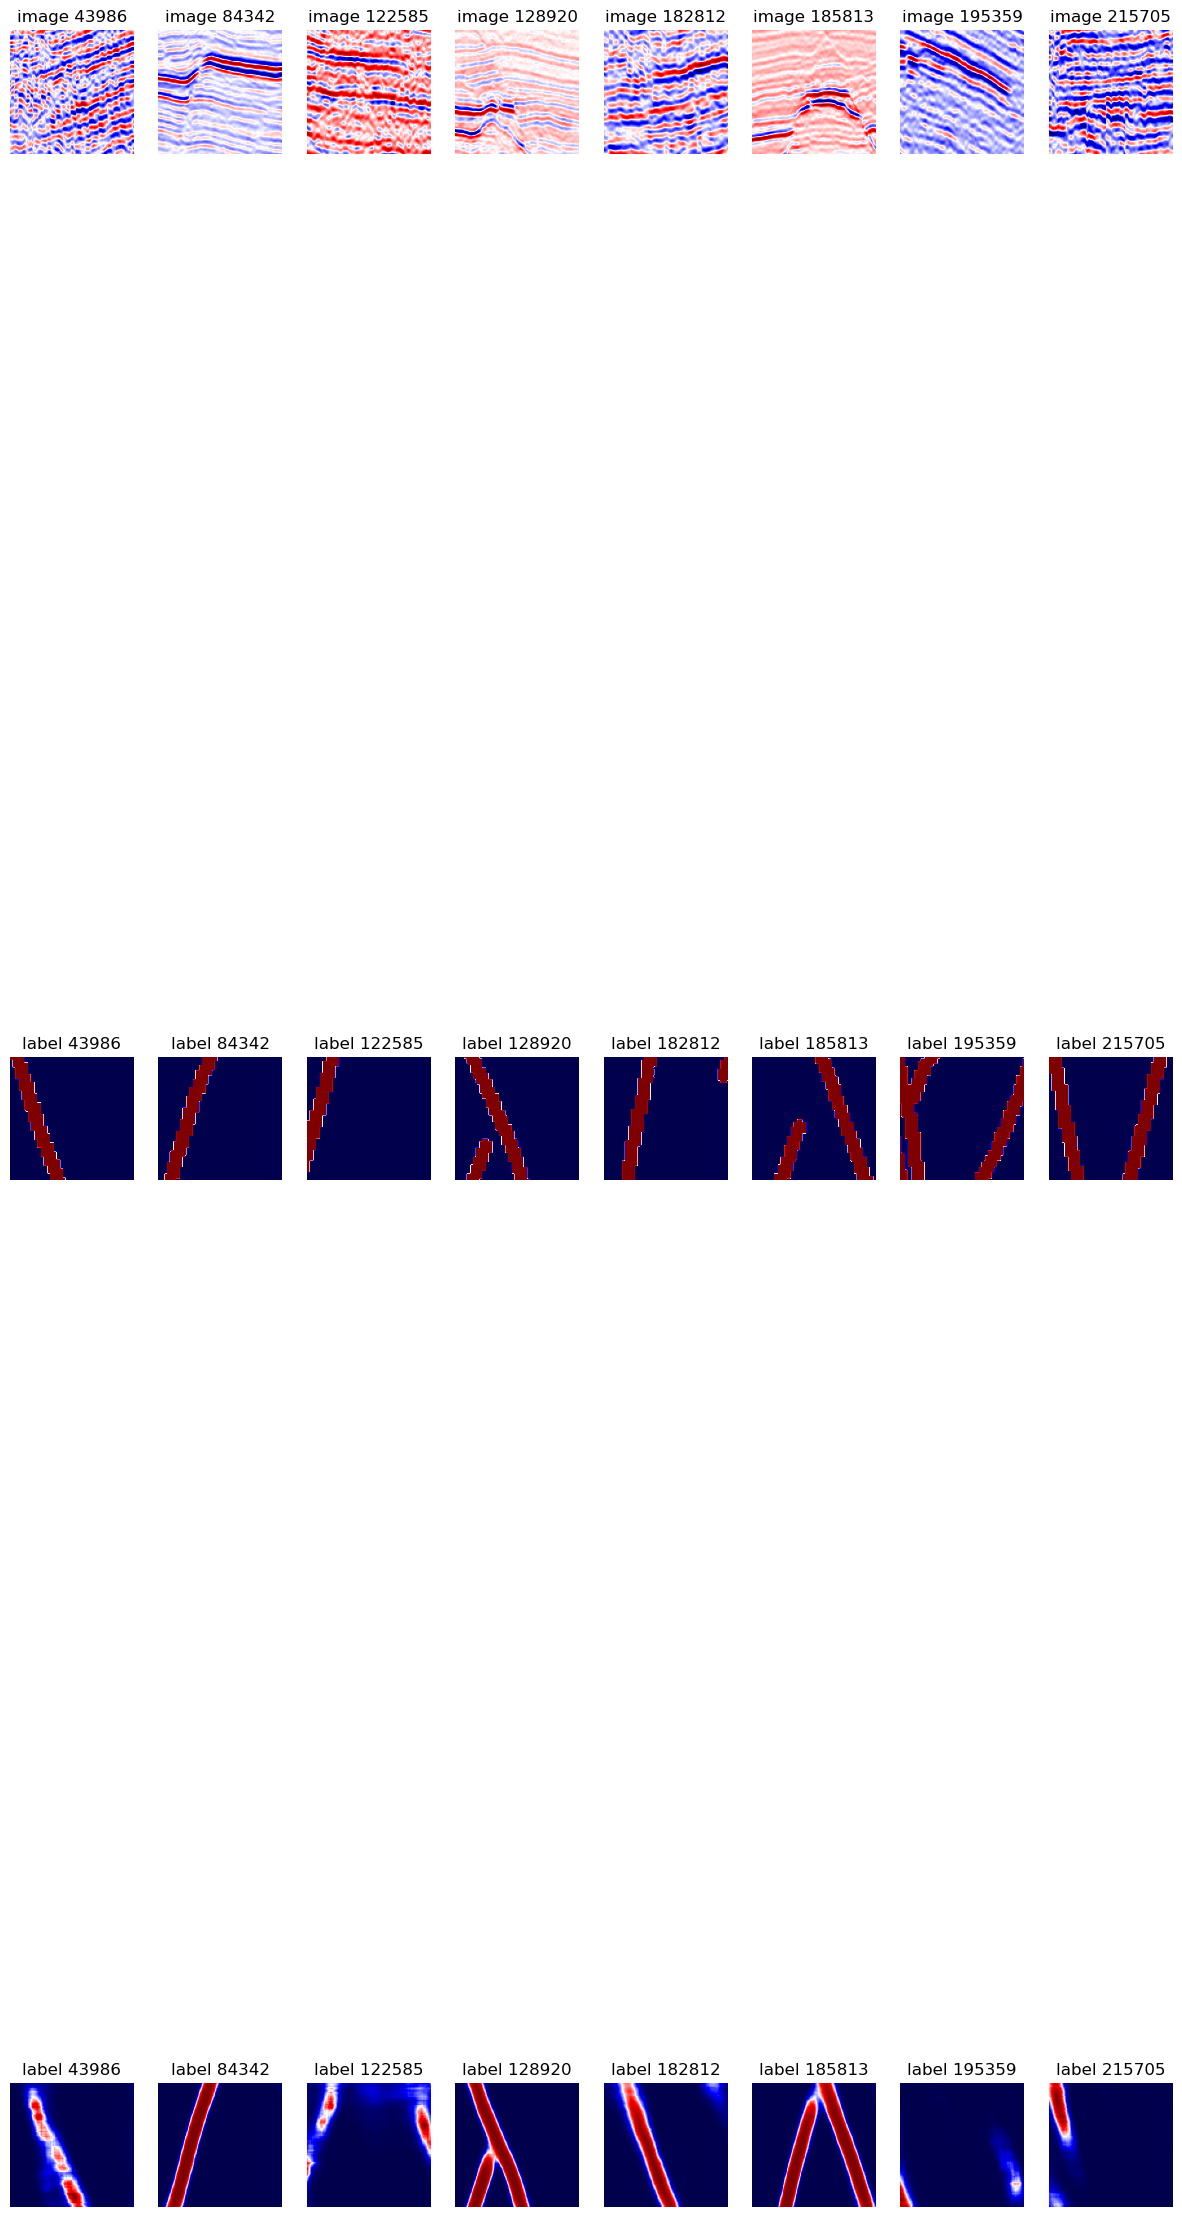

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___112.64___minutes
                      0             1  accuracy     macro avg  weighted avg
precision  9.400000e-01  6.700000e-01      0.92  8.000000e-01  9.100000e-01
recall     9.700000e-01  4.900000e-01      0.92  7.300000e-01  9.200000e-01
f1-score   9.500000e-01  5.600000e-01      0.92  7.600000e-01  9.100000e-01
support    1.841265e+09  2.242436e+08      0.92  2.065508e+09  2.065508e+09
{'Avg-precision': 0.63, 'f1-score(ODS)': 0.56}
